## Tasca 6. Visualització

### Importem les llibreries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import time

import warnings
warnings.simplefilter('ignore')

### Carreguem les dades

In [2]:
file = '../data/DelayedFlights.csv'
types = {'DepTime':str, 'CRSDepTime':str, 'ArrTime':str, 'CRSarrTime':str}

delayed_flights = pd.read_csv(file, dtype=types)

In [3]:
# importem la taula de companyies 

carrier_file = '../data/Unique_carriers.csv'
carriers = pd.read_csv(carrier_file, index_col=0).to_dict()['Description']

# i d'aeroports.

airports = pd.read_csv('http://stat-computing.org/dataexpo/2009/airports.csv', index_col=0)



In [4]:
airports.country.unique()

array(['USA', 'Thailand', 'Palau', 'N Mariana Islands',
       'Federated States of Micronesia'], dtype=object)

In [5]:
airports[airports.index.isin( delayed_flights.Origin.unique().tolist())]

,airport,city,state,country,lat,long
iata,,,,,,
ABE,Lehigh Valley International,Allentown,PA,USA,40.652363,-75.440402
ABI,Abilene Regional,Abilene,TX,USA,32.411320,-99.681897
ABQ,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194
ABY,Southwest Georgia Regional,Albany,GA,USA,31.535515,-84.194473
ACK,Nantucket Memorial,Nantucket,MA,USA,41.253052,-70.060181
...,...,...,...,...,...,...
WYS,Yellowstone,West Yellowstone,MT,USA,44.688399,-111.117638
XNA,Northwest Arkansas Regional,Fayetteville/Springdale/Rogers,AR,USA,36.281869,-94.306811
YAK,Yakutat,Yakutat,AK,USA,59.503361,-139.660226


<AxesSubplot:>

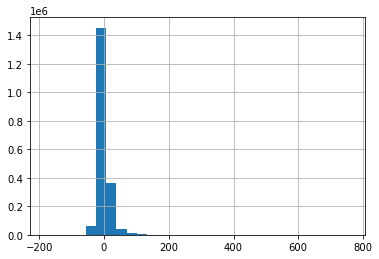

In [6]:
(delayed_flights.ArrDelay - delayed_flights.DepDelay).hist(bins=30)

In [7]:
delayed_flights.Origin.map(airports.country.to_dict())

0          USA
1          USA
2          USA
3          USA
4          USA
          ... 
1936753    USA
1936754    USA
1936755    USA
1936756    USA
1936757    USA
Name: Origin, Length: 1936758, dtype: object

In [8]:
delayed_flights.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


### Preprocés

Utilitzant les transformacions de la tasca anterior, modifiquem el DataFrame

In [9]:
DELAYED_MIN = 10
NO_DELAY = 0

delayed_flights['carrier_name'] = delayed_flights.UniqueCarrier.map(carriers)
delayed_flights['Origin'] = delayed_flights.Origin.map(airports.airport.to_dict())
delayed_flights['Dest'] = delayed_flights.Dest.map(airports.airport.to_dict())

cols_retras = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
delayed_flights[cols_retras] = delayed_flights[cols_retras].fillna(value=0.0)


# Sabem que les 2400.0 son les 00.00
delayed_flights.loc[delayed_flights.DepTime.astype(float)==2400,'DepTime'] = '0.0'

delayed_flights['DepartureTime'] = delayed_flights.apply(lambda x: datetime(int(x.Year), 
                                       int(x.Month), 
                                       int(x.DayofMonth), 
                                       int(x.DepTime.split('.')[0].zfill(4)[:-2]), 
                                       int(x.DepTime.split('.')[0].zfill(4)[-2:])), axis=1)

delayed_flights['CRSDepartureTime'] = delayed_flights.apply(lambda x: datetime(int(x.Year),
                                       int(x.Month), 
                                       int(x.DayofMonth), 
                                       int(x.CRSDepTime.zfill(4)[:-2]), 
                                       int(x.CRSDepTime.zfill(4)[-2:])), axis=1)

delayed_flights['no_vol'] = delayed_flights.Cancelled + delayed_flights.Diverted

delayed_flights['endarrerit'] = delayed_flights.ArrDelay > DELAYED_MIN

In [10]:
# delayed_flights.loc[delayed_flights.ArrDelay < DELAYED_MIN, 'ArrDelay'] = 0

Aeroports d'arribada que no tenen vols de sortida

In [11]:
set(delayed_flights.Dest.unique()) - set(delayed_flights.Origin.unique())

{'Cheyenne', 'Ogden-Hinckley'}

Aeroports de sortida als que no arriba cap avió

In [12]:
set(delayed_flights.Origin.unique()) - set(delayed_flights.Dest.unique())

{'Pueblo Memorial'}

##### Detectar Outliers

In [14]:
cols = ['Origin','Dest','Distance','ActualElapsedTime', 'AirTime', 'CRSElapsedTime','DepDelay','ArrDelay']
delayed_flights[cols].describe().round(3)

,Distance,ActualElapsedTime,AirTime,CRSElapsedTime,DepDelay,ArrDelay
count,1936758.000,1928371.000,1928371.000,1936560.000,1936758.000,1928371.000
mean,765.686,133.306,108.277,134.303,43.185,42.200
std,574.480,72.060,68.643,71.341,53.403,56.785
min,11.000,14.000,0.000,-25.000,6.000,-109.000
25%,338.000,80.000,58.000,82.000,12.000,9.000
50%,606.000,116.000,90.000,116.000,24.000,24.000
75%,998.000,165.000,137.000,165.000,53.000,56.000
max,4962.000,1114.000,1091.000,660.000,2467.000,2461.000


In [15]:
def IQR(df, columns=None, q1=0.25, q3=0.75, scale=1.5):
    if columns:
        df = df[columns]
    iqr = df.quantile(q3) - df.quantile(q1)
    return ((df.quantile(q1) - scale * iqr).values, 
            (df.quantile(q3) + scale * iqr).values)    

IQR(delayed_flights, columns=cols )

(array([-652. ,  -47.5,  -60.5,  -42.5,  -49.5,  -61.5]),
 array([1988. ,  292.5,  255.5,  289.5,  114.5,  126.5]))

Sobre els outliers, hem de tenir en compte que, com veurem, les dades no segueixen una distribució gaussiana.
Per exemple, la distancia no pot ser negativa, i tenim outliers per sota negatius. 


In [16]:
delayed_flights[delayed_flights.AirTime > 900]

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,carrier_name,DepartureTime,CRSDepartureTime,no_vol,endarrerit
1488690,5180146,2008,9,9,2,1411.0,920,545.0,1215,HA,...,1040.0,0.0,0.0,0.0,10.0,Hawaiian Airlines Inc.,2008-09-09 14:11:00,2008-09-09 09:20:00,0,True


In [17]:
columnes = ['CRSArrTime','CRSElapsedTime', 'ArrTime', 'DepTime','ActualElapsedTime', 'Origin','Dest', 'Cancelled','Diverted']
delayed_flights[delayed_flights.ArrDelay < -60][columnes]

,CRSArrTime,CRSElapsedTime,ArrTime,DepTime,ActualElapsedTime,Origin,Dest,Cancelled,Diverted
50338,1911,130.0,1805.0,1708.0,57.0,LaGuardia,Port Columbus Intl,0,0
50752,2155,320.0,2049.0,1743.0,246.0,John F Kennedy Intl,Austin-Bergstrom International,0,0
85894,2249,389.0,2148.0,1933.0,315.0,Gen Edw L Logan Intl,McCarran International,0,0
109745,2359,164.0,2252.0,1930.0,82.0,Denver Intl,William B Hartsfield-Atlanta Intl,0,0
352034,1310,370.0,1202.0,907.0,295.0,John Wayne /Orange Co,Kona International At Keahole,0,0
493007,1426,318.0,1317.0,1218.0,239.0,William B Hartsfield-Atlanta Intl,Phoenix Sky Harbor International,0,0
497550,540,320.0,438.0,2127.0,251.0,San Diego International-Lindbergh,Orlando International,0,0
1036657,2215,400.0,2112.0,1843.0,329.0,Newark Intl,Los Angeles International,0,0
1110539,1520,170.0,1331.0,1449.0,42.0,Austin-Bergstrom International,San Diego International-Lindbergh,0,0
1323632,103,413.0,2400.0,2118.0,342.0,John F Kennedy Intl,San Francisco International,0,0


### Exercici 1
Resumeix gràficament el data set DelayedFlights.csv

Crea almenys una visualització per:

- [ ] Una variable categòrica (UniqueCarrier)  

In [18]:
delayed_flights.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,carrier_name,DepartureTime,CRSDepartureTime,no_vol,endarrerit
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 20:03:00,2008-01-03 19:55:00,0,False
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 07:54:00,2008-01-03 07:35:00,0,False
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 06:28:00,2008-01-03 06:20:00,0,True
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,2.0,0.0,0.0,0.0,32.0,Southwest Airlines Co.,2008-01-03 18:29:00,2008-01-03 17:55:00,0,True
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 19:40:00,2008-01-03 19:15:00,0,True


In [19]:
data = delayed_flights.UniqueCarrier.value_counts()

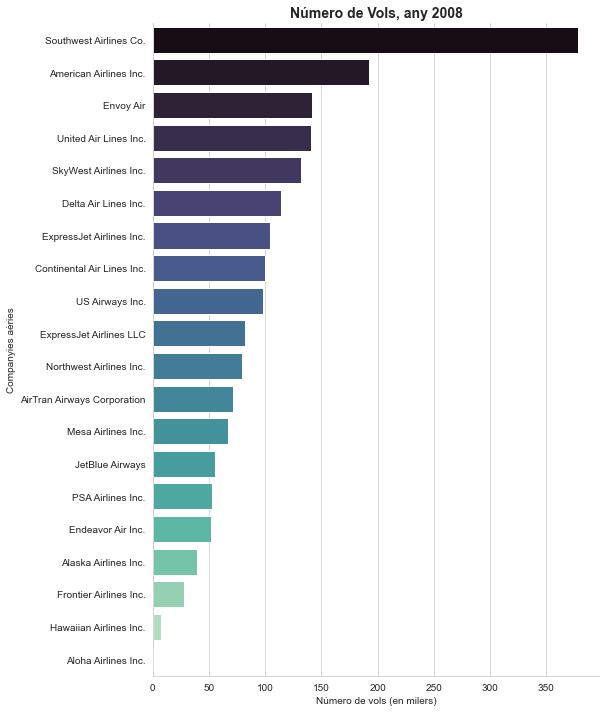

In [20]:
plt.figure(figsize=(8,12))
sns.set_style('whitegrid')
ax = sns.barplot(data=data, y=data.index.map(carriers), x=np.round(data.values/1000,0),
           palette='mako', orient='h')

ax.set_title(f'Número de Vols, any {delayed_flights.Year.unique()[0]}', 
             fontdict={'fontsize':14, 'fontweight':'bold' })
ax.set(xlabel='Número de vols (en milers)', ylabel='Companyies aèries')
sns.despine()

In [21]:
group = delayed_flights.groupby('UniqueCarrier').agg({'ArrDelay':['count','sum','mean'],'DepDelay':['sum','mean']})
# renombrem les columnes
group.columns = ['_'.join(col).strip('_') for col in group.columns.values]
# group.droplevel(0, axis=1)
group.reset_index(inplace=True)

In [22]:
group.head()

,UniqueCarrier,ArrDelay_count,ArrDelay_sum,ArrDelay_mean,DepDelay_sum,DepDelay_mean
0,9E,51569,2420468.0,46.936493,2457810.0,47.370338
1,AA,190910,8889066.0,46.561553,8918260.0,46.481953
2,AQ,744,15814.0,21.255376,20010.0,26.680000
3,AS,39010,1406735.0,36.060882,1504939.0,38.300435
4,B6,54925,3025749.0,55.088739,3044016.0,55.030570


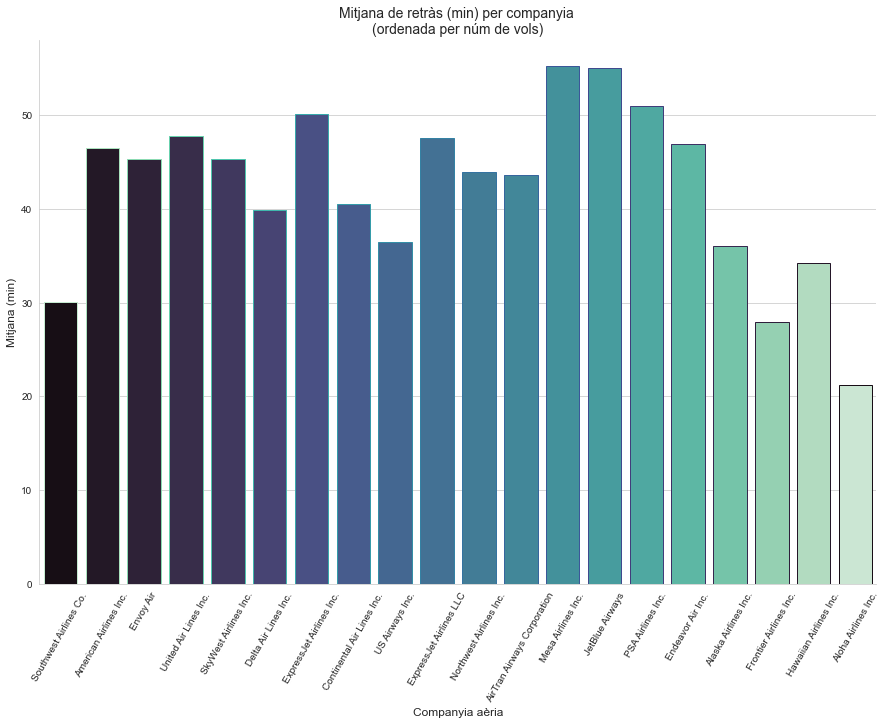

In [27]:
plt.figure(figsize=(15,10))
data = group.reset_index().sort_values([('ArrDelay_count')], ascending=False)
ax = sns.barplot(data=data,
            x=data['UniqueCarrier'].map(carriers), y='ArrDelay_mean',
            palette='mako',
#             facecolor='none',
            edgecolor=sns.color_palette("mako_r", len(data.UniqueCarrier.unique())),
            )

#https://stackoverflow.com/questions/56075639/labels-are-printed-when-set-xticklabels-called
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=60, )
_ = ax.set_title("Mitjana de retràs (min) per companyia \n(ordenada per núm de vols)", 
                 fontdict={'fontsize':14})

ax.set_xlabel('Companyia aèria', fontdict={'fontsize':12})
ax.set_ylabel('Mitjana (min)', fontdict={'fontsize':12,})
sns.despine()


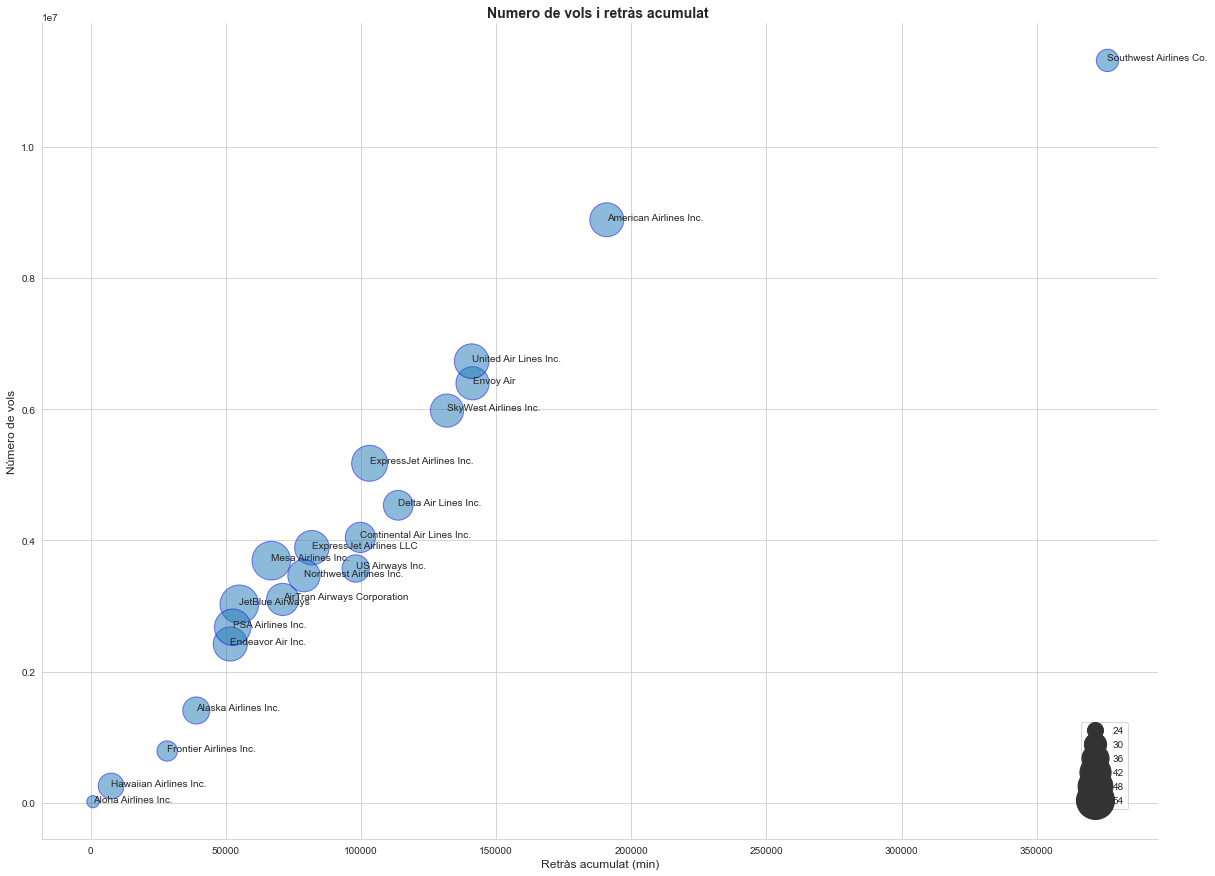

In [26]:
plt.figure(figsize=(20,15))
data = group
data['carrier_name'] = data.UniqueCarrier.map(carriers)
ax = sns.scatterplot(data=data, x='ArrDelay_count', y='ArrDelay_sum', size='ArrDelay_mean',
                alpha=0.5,
                edgecolor='blue',
                palette='mako',
                linewidth=1,
                sizes=(150,1500))

for line in range(0,data.shape[0]):
    ax.text(data.iloc[line].ArrDelay_count+2, data.iloc[line].ArrDelay_sum, 
           data.iloc[line].carrier_name)

_ = ax.set_title("Numero de vols i retràs acumulat ", 
                 fontdict={'fontsize':14, 'fontweight':'bold'})

ax.set_xlabel('Retràs acumulat (min)', fontdict={'fontsize':12})
ax.set_ylabel('Número de vols', fontdict={'fontsize':12,})
ax.legend(loc='lower right', borderaxespad=3)
sns.despine()

- [ ] Una variable numèrica (ArrDelay)  

<AxesSubplot:xlabel='ArrDelay', ylabel='Count'>

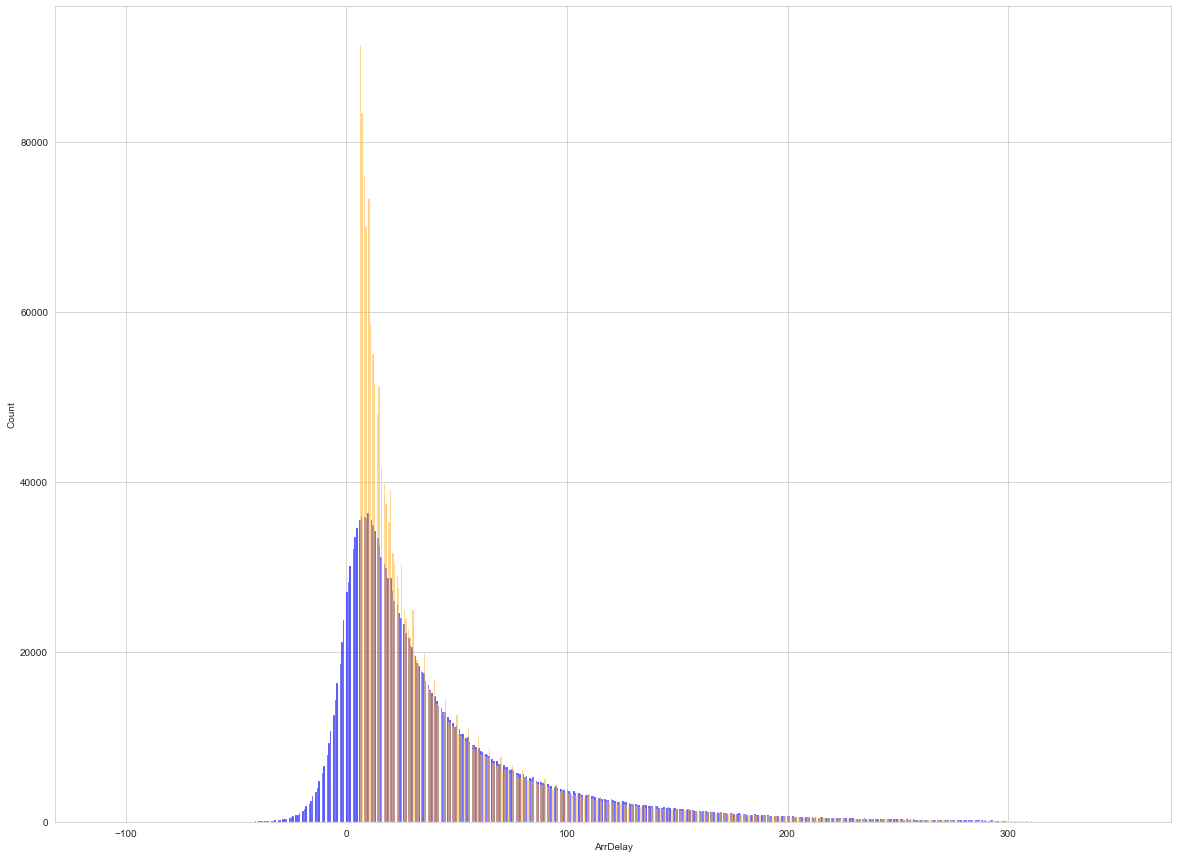

In [27]:
plt.figure(figsize=(20,15))

sns.histplot(x=delayed_flights[delayed_flights.ArrDelay<300].ArrDelay, color='blue', alpha=0.7)
sns.histplot(x=delayed_flights[delayed_flights.ArrDelay<300].DepDelay, color='orange', alpha=0.5)

In [28]:
IQR(delayed_flights,['ArrDelay','DepDelay'])[1][0]

126.5

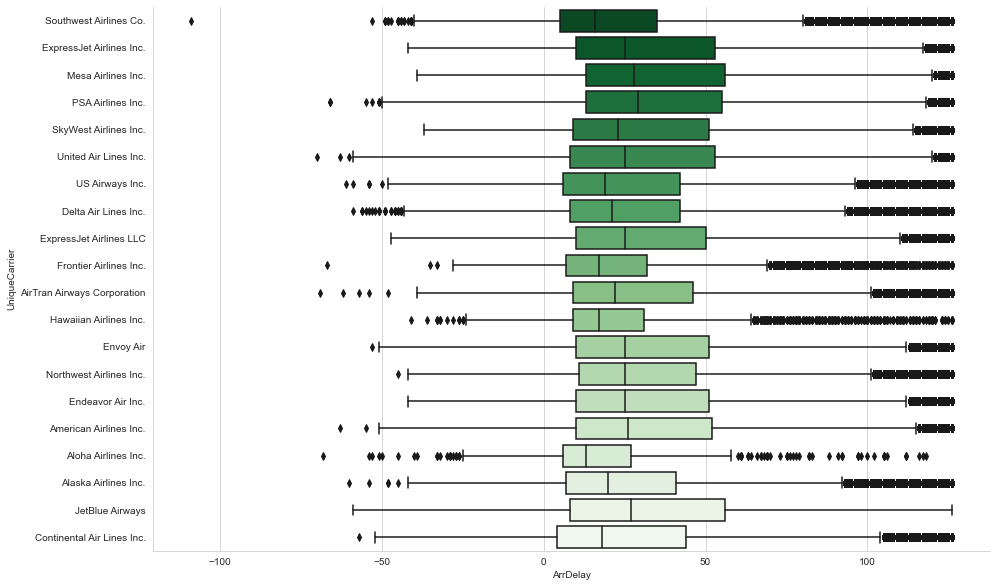

In [29]:
plt.figure(figsize=(15,10))
data = delayed_flights[delayed_flights.ArrDelay < IQR(delayed_flights,['ArrDelay'])[1][0]]
sns.boxplot(data=data, y=data.UniqueCarrier.map(carriers), x='ArrDelay',
           orient='h', palette='Greens_r')
sns.despine()

<AxesSubplot:xlabel='UniqueCarrier', ylabel='ArrDelay'>

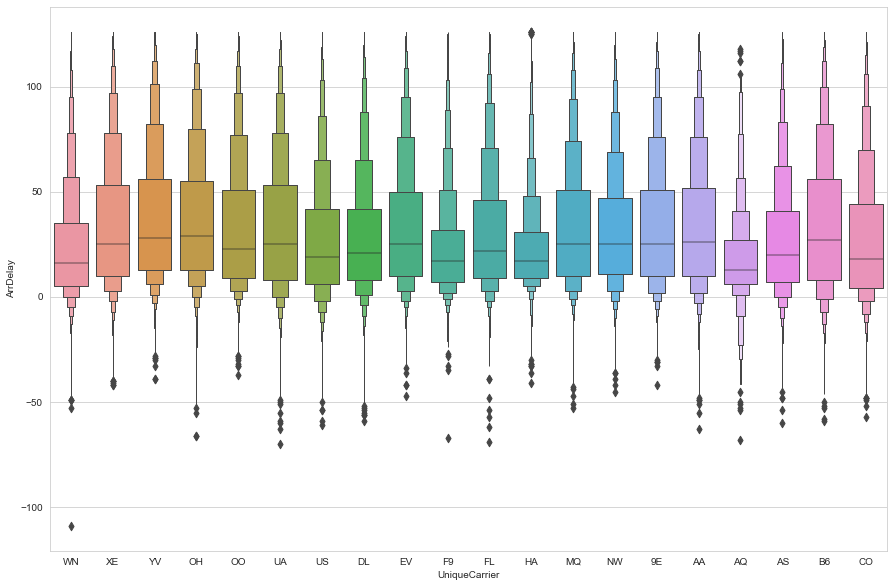

In [30]:
plt.figure(figsize=(15,10))
sns.boxenplot(data=data, x='UniqueCarrier', y='ArrDelay')

- [ ] Una variable numèrica i una categòrica (ArrDelay i UniqueCarrier)  

In [31]:
delayed_flights.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,carrier_name,DepartureTime,CRSDepartureTime,no_vol,endarrerit
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 20:03:00,2008-01-03 19:55:00,0,False
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 07:54:00,2008-01-03 07:35:00,0,False
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 06:28:00,2008-01-03 06:20:00,0,True
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,2.0,0.0,0.0,0.0,32.0,Southwest Airlines Co.,2008-01-03 18:29:00,2008-01-03 17:55:00,0,True
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,0.0,0.0,0.0,0.0,0.0,Southwest Airlines Co.,2008-01-03 19:40:00,2008-01-03 19:15:00,0,True


<Figure size 1080x2160 with 0 Axes>

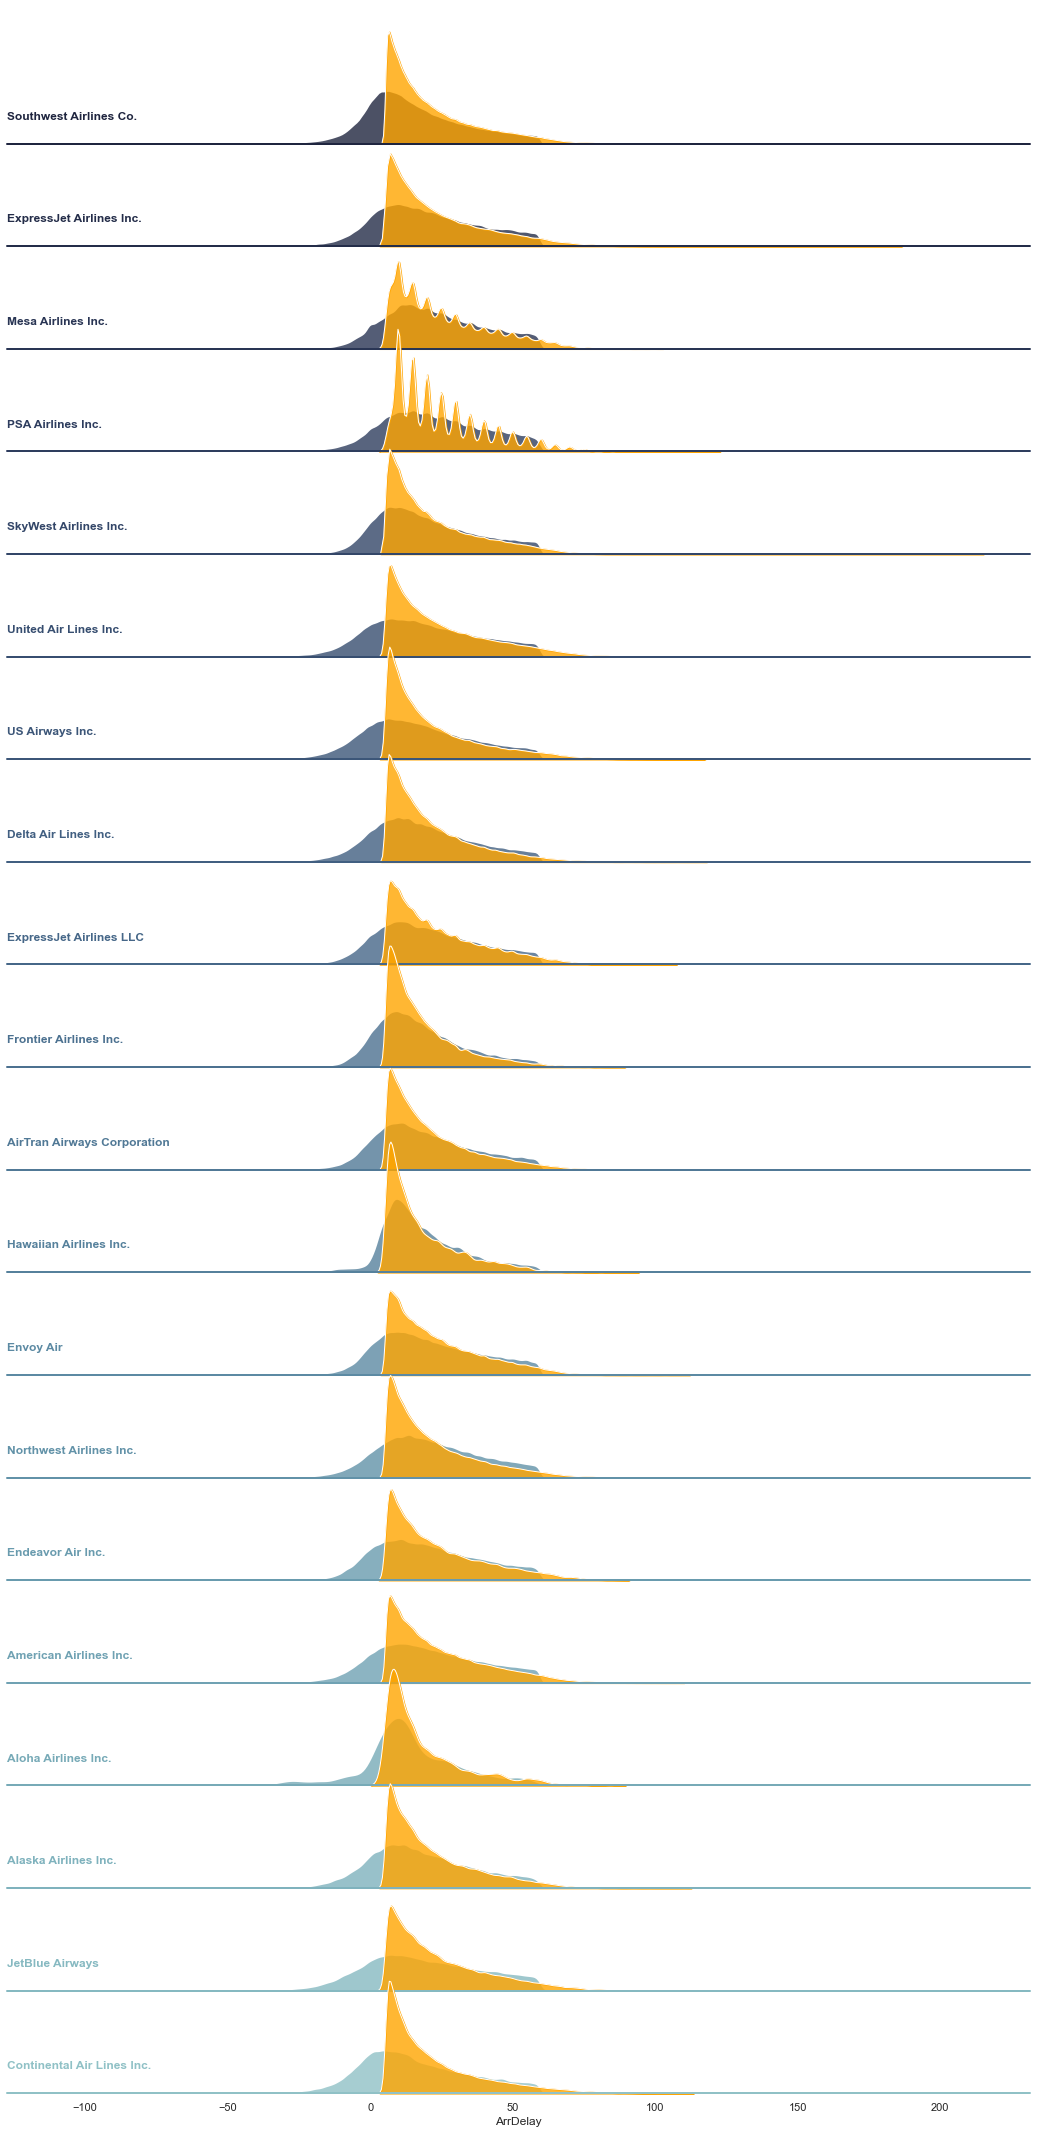

In [32]:
# https://seaborn.pydata.org/examples/kde_ridgeplot

plt.figure(figsize=(15,30))
# Initialize the FacetGrid object
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(delayed_flights.carrier_name.nunique(), rot=-.25, light=.7, reverse=True)
data = delayed_flights[delayed_flights.ArrDelay < 60]
g = sns.FacetGrid(data, row="UniqueCarrier", hue='carrier_name', aspect=10, height=1.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "ArrDelay",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.8, linewidth=0.)
# g.map(sns.kdeplot, "ArrDelay", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Draw the densities in a few steps
g.map(sns.kdeplot, "DepDelay",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.8, linewidth=1.5, color='orange')
g.map(sns.kdeplot, "DepDelay", clip_on=False, color="w", lw=1, bw_adjust=.5)

g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "ArrDelay")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

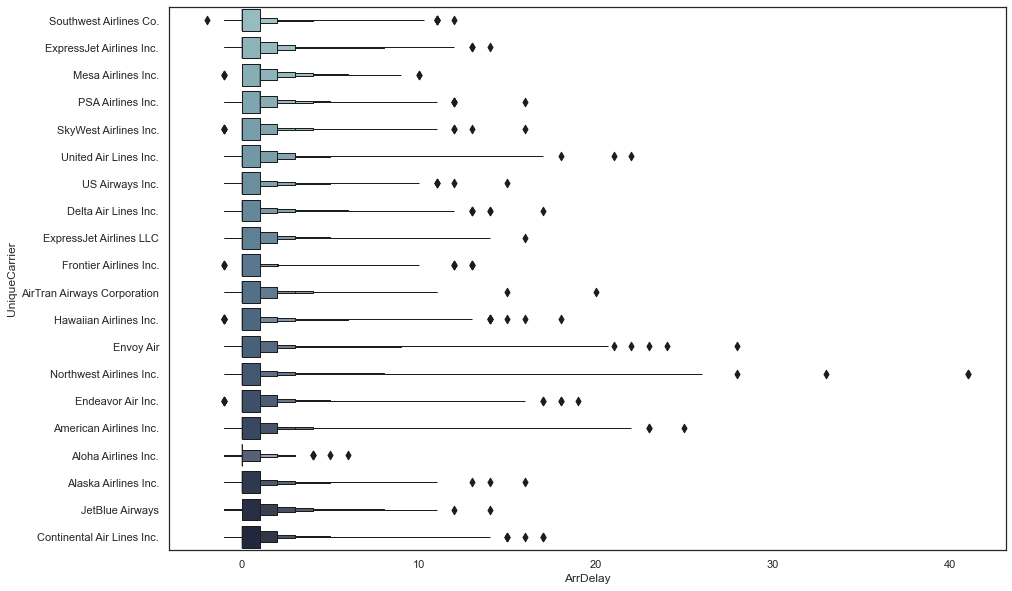

In [33]:
plt.figure(figsize=(15,10))

pal = sns.cubehelix_palette(delayed_flights.carrier_name.nunique(), rot=-.25, light=.7)


mask = (delayed_flights.Cancelled == 0) & (delayed_flights.Diverted== 0)
ax = sns.boxenplot(data=delayed_flights[mask], y=delayed_flights[mask].UniqueCarrier.map(carriers), 
                 x=np.round(delayed_flights[mask].ArrDelay/60,0), orient='h', palette=pal)

# ax.set_xticklabels(ax.get_xticklabels(),rotation=60)

- [ ] Dues variables numèriques (ArrDelay i DepDelay)  

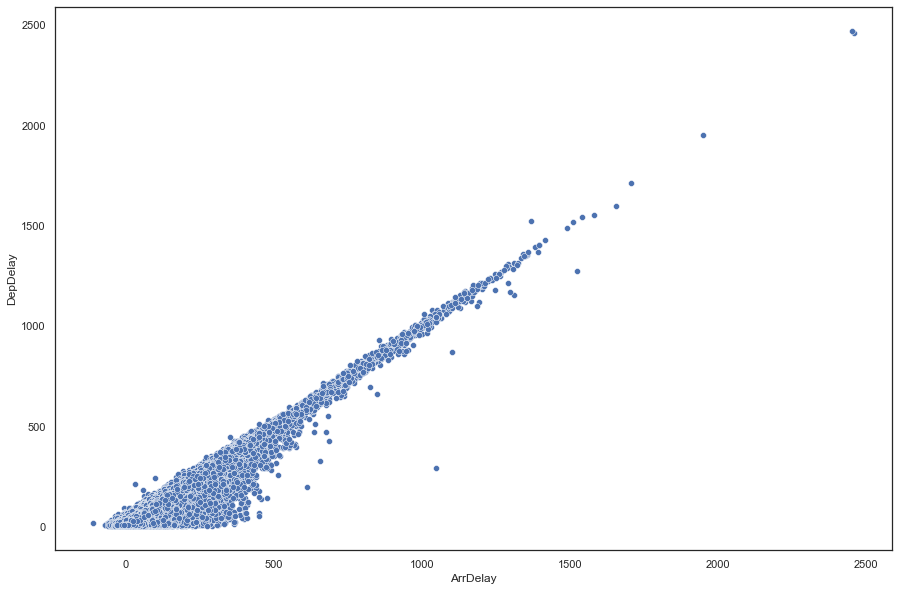

In [34]:
plt.figure(figsize=(15,10))

ax = sns.scatterplot(data=delayed_flights, x='ArrDelay', y='DepDelay', )
# ax.set(xscale="log", yscale="log")

- [ ] Tres variables (ArrDelay, DepDelay i UniqueCarrier)  

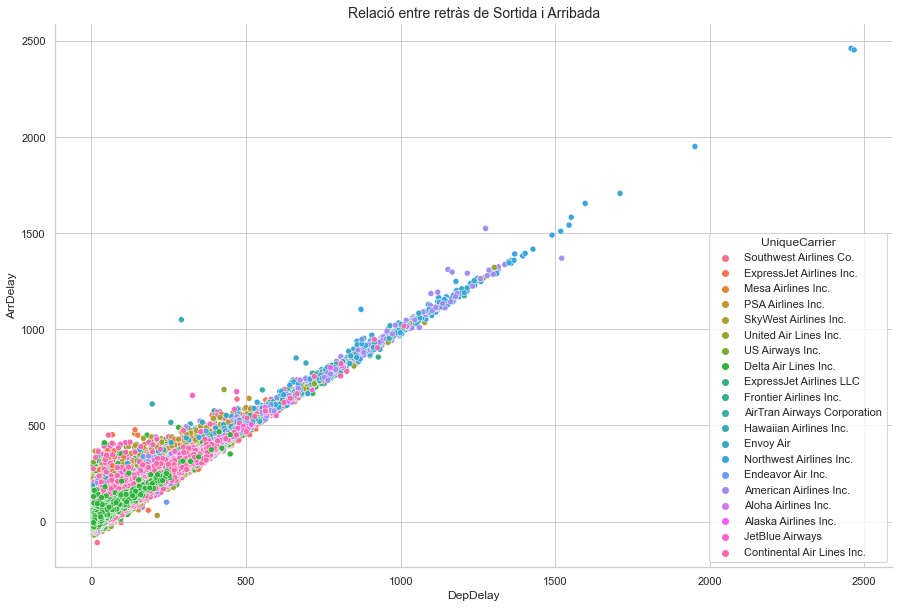

In [35]:
plt.figure(figsize=(15,10))
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(data=delayed_flights, 
                x='DepDelay', y='ArrDelay', 
                hue=delayed_flights.UniqueCarrier.map(carriers))
_ = ax.set_title('Relació entre retràs de Sortida i Arribada', fontdict={'fontsize':14})

sns.despine()

- [ ] Més de tres variables (ArrDelay, DepDelay, AirTime i UniqueCarrier).  

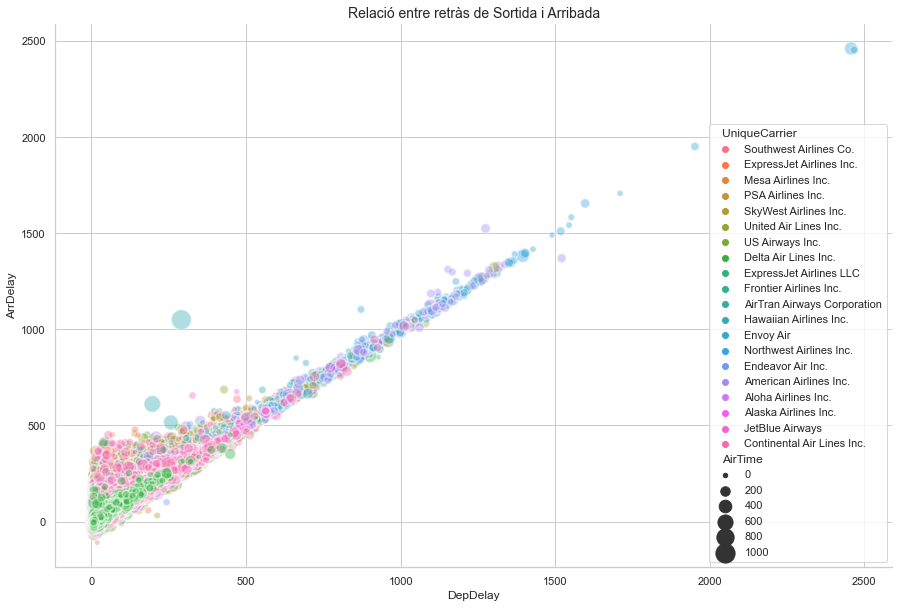

In [36]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=delayed_flights, 
                x='DepDelay', y='ArrDelay', 
                hue=delayed_flights.UniqueCarrier.map(carriers),
                size='AirTime', sizes=(20,400),
                alpha=0.4,
                linewidth=1.5)
_ = ax.set_title('Relació entre retràs de Sortida i Arribada', fontdict={'fontsize':14})

sns.despine()

In [37]:
group['carrier_name'] = group.UniqueCarrier.map(carriers)


In [38]:
group.head()

,UniqueCarrier,ArrDelay_count,ArrDelay_sum,ArrDelay_mean,DepDelay_sum,DepDelay_mean,carrier_name
0,9E,51569,2420468.0,46.936493,2457810.0,47.370338,Endeavor Air Inc.
1,AA,190910,8889066.0,46.561553,8918260.0,46.481953,American Airlines Inc.
2,AQ,744,15814.0,21.255376,20010.0,26.680000,Aloha Airlines Inc.
3,AS,39010,1406735.0,36.060882,1504939.0,38.300435,Alaska Airlines Inc.
4,B6,54925,3025749.0,55.088739,3044016.0,55.030570,JetBlue Airways


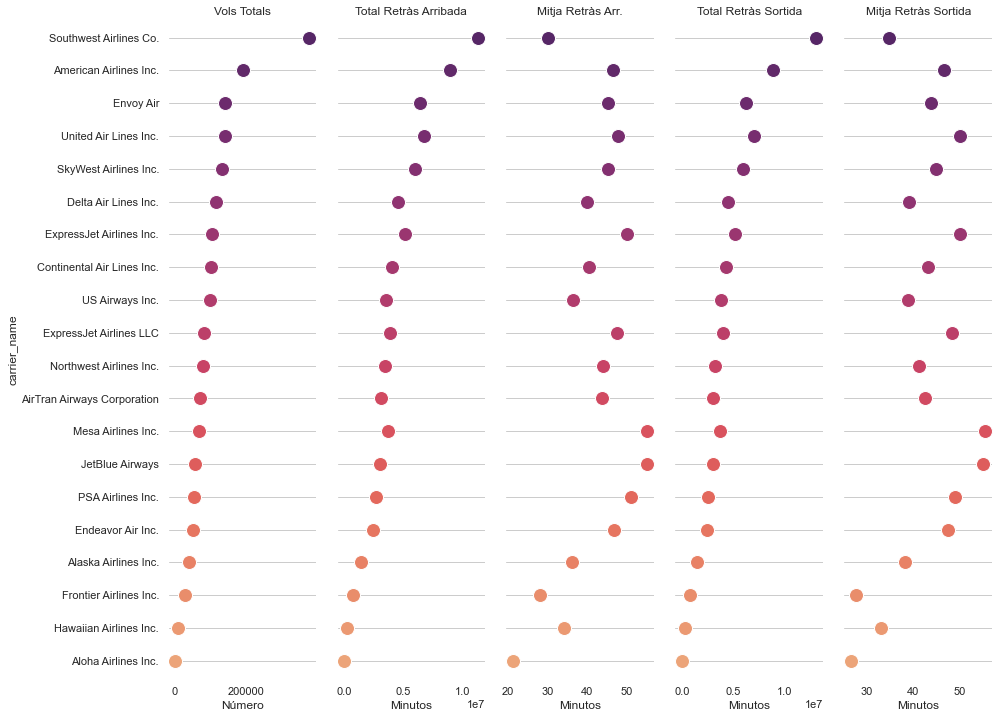

In [39]:
g = sns.PairGrid(group.sort_values('ArrDelay_count',ascending=False),
            x_vars=group.columns[-6:-1], y_vars=['carrier_name'],
            height=10, aspect=.25)

g.map(sns.stripplot, size=14, orient='h', jitter=False, palette='flare_r', linewidth=1, edgecolor='w')

# g.set(xlim=(0,25), xlabel='Minutes', ylabel='')
titles = ['Vols Totals','Total Retràs Arribada','Mitja Retràs Arr.','Total Retràs Sortida','Mitja Retràs Sortida']
etiquetasx = ['Número'] + ['Minutos']*4
for ax, title, etiqx in zip(g.axes.flat, titles, etiquetasx):
    ax.set(title = title)
    ax.set(xlabel=etiqx)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)

<AxesSubplot:xlabel='ArrDelay', ylabel='Density'>

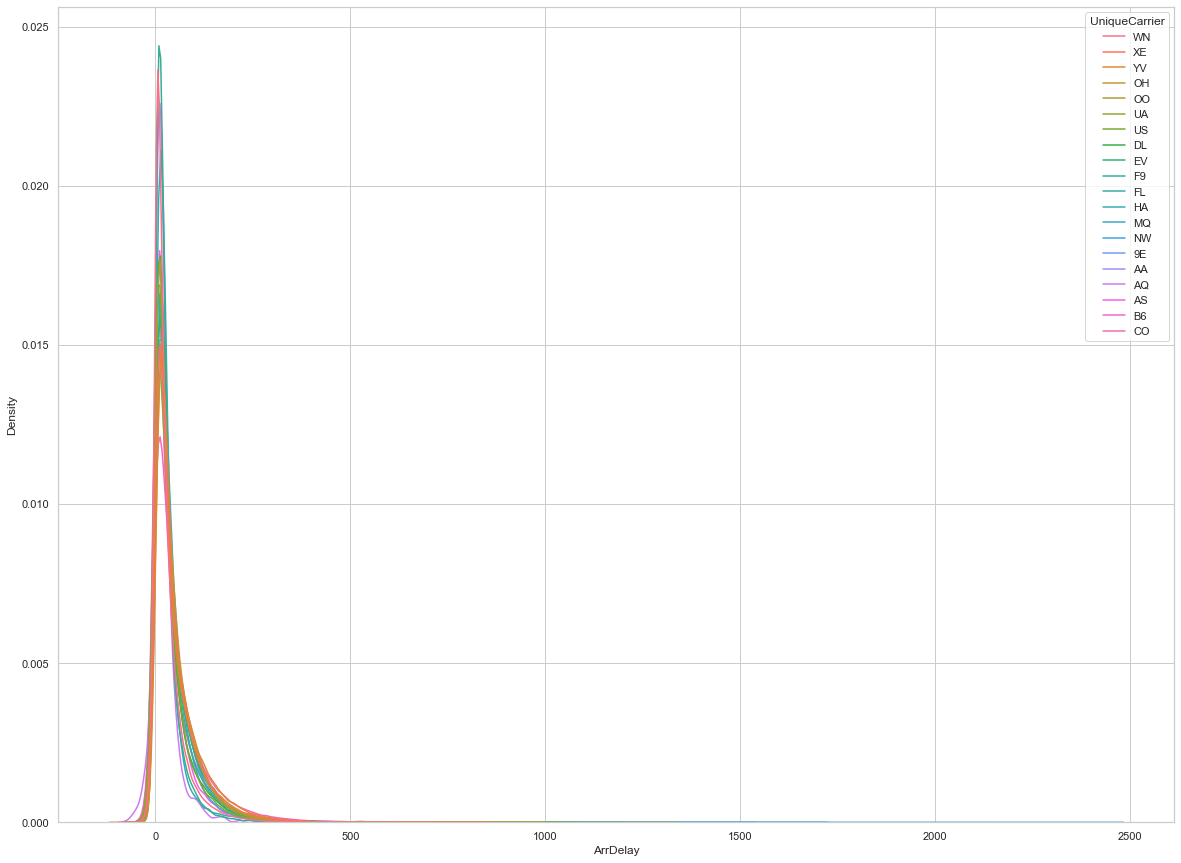

In [40]:
plt.figure(figsize=(20,15))
sns.kdeplot(x=delayed_flights.ArrDelay, hue=delayed_flights.UniqueCarrier, common_norm=False)

#### Connexions i vols

In [41]:
vols_aeroport = delayed_flights.groupby(['Origin','Dest']).UniqueCarrier.count().reset_index()
vols_aeroport.columns = ['Origin','Dest','Vols']
vols_aeroport.head()

,Origin,Dest,Vols
0,Abilene Regional,Dallas-Fort Worth International,392
1,Adak,Ted Stevens Anchorage International,53
2,Adams,Baltimore-Washington International,194
3,Adams,Charlotte/Douglas International,3
4,Adams,Chicago Midway,136


<AxesSubplot:xlabel='Dest', ylabel='Origin'>

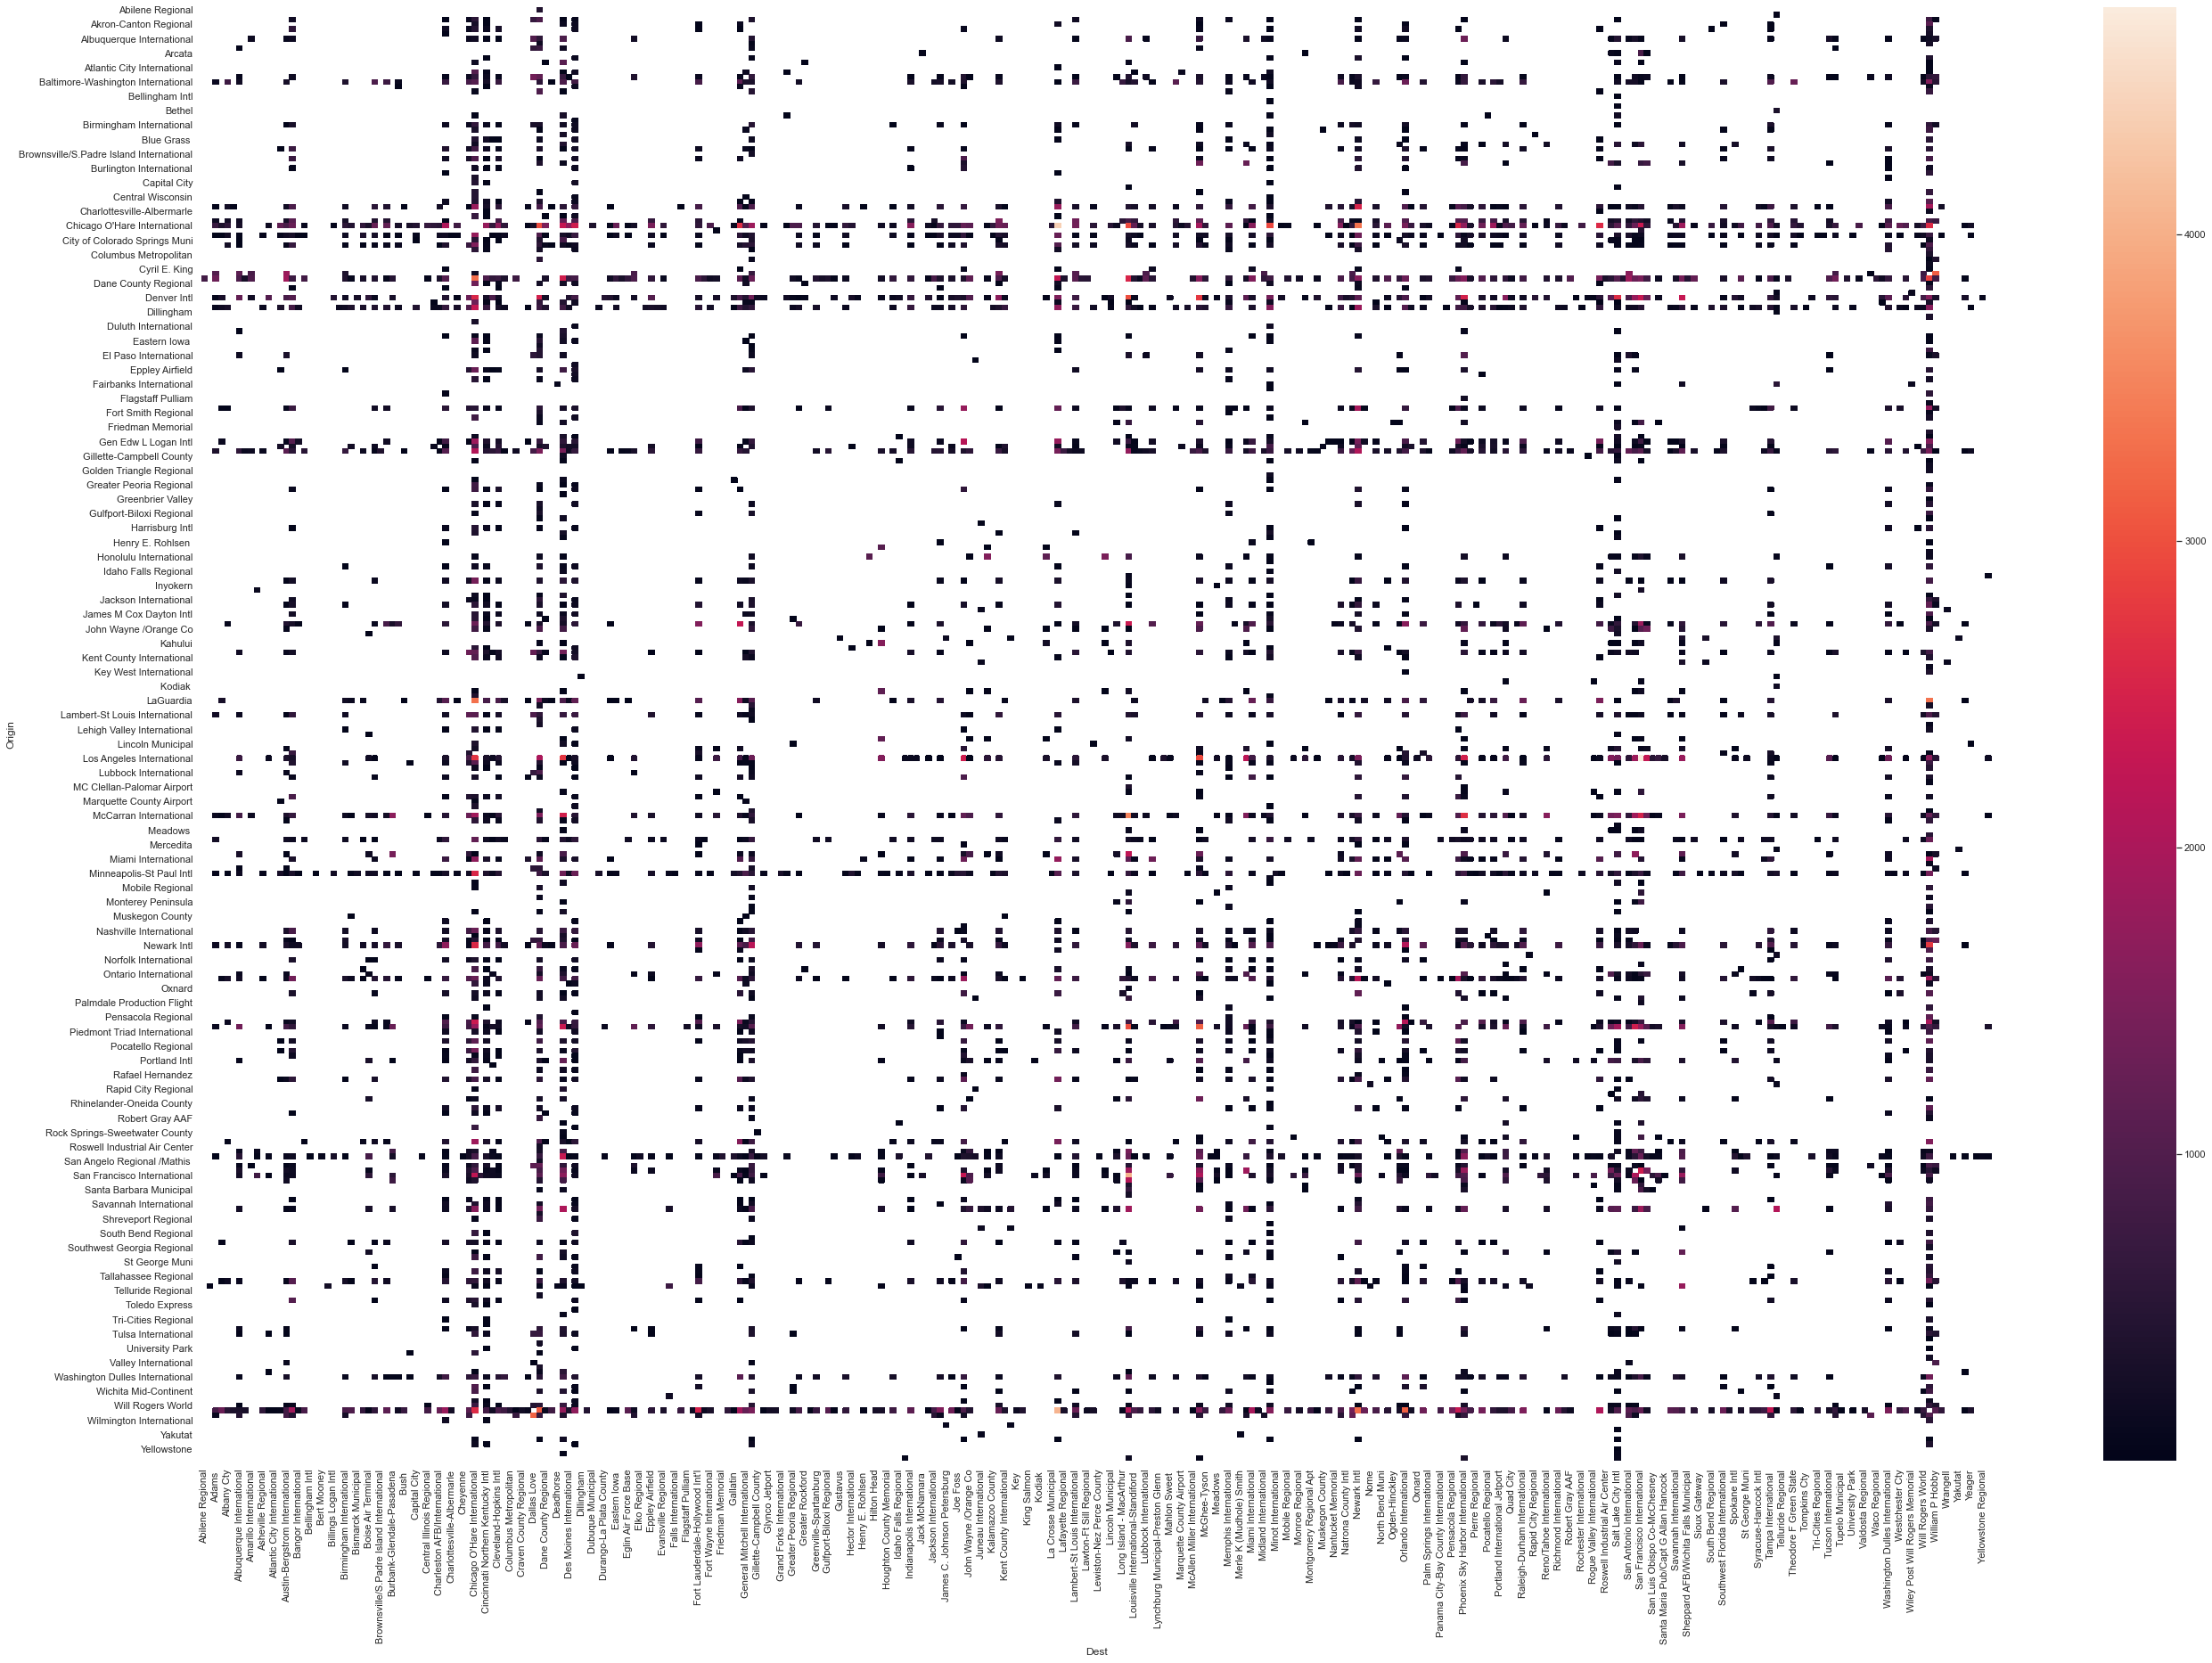

In [42]:
plt.figure(figsize=(45,30))

sns.heatmap(vols_aeroport.pivot_table(index='Origin',columns='Dest',values='Vols'))

In [43]:
vols_aeroport.pivot_table(index='Origin',columns='Dest',values='Vols', )

Dest,Abilene Regional,Adak,Adams,Akron-Canton Regional,Albany Cty,Albert J Ellis,Albuquerque International,Alexandria International,Amarillo International,Arcata,...,William P Hobby,Wilmington International,Wrangell,Yakima Air Terminal,Yakutat,Yampa Valley,Yeager,Yellowstone,Yellowstone Regional,Yuma MCAS-Yuma International
Origin,,,,,,,,,,,,,,,,,,,,,
Abilene Regional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akron-Canton Regional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albany Cty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yampa Valley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yeager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yellowstone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exercici 2
Exporta els gràfics com imatges o com html.

### Exercici 3
Exporta el data set net i amb les noves columnes a Excel.

### Exercici 4
Integra les visualitzacions gràfiques, en la tasca 5, del Sprint 3.